In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=9ae1b0ea201d3db9fafd1684a116eb5e462e25344d40c85c6c352ddcbdf5a60c
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
from pyspark.sql.functions import col, min, max, floor
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext

df = spark.read.option('header', True).csv("/content/LP_SAMPLE_DATA.csv")
df.show()

+--------------------------+------------------------+--------------------+---------------+-------------------------+--------------------+-----------------------+--------------------------+--------------------+----------------------+-----------------------+------------------------+--------------------+--------------------------+-----------------------+----------------------------+---------------------+----------------------+----------------------------------+------------------------+-------------------------------------+-----------------------------+------------------------------------+----------------------------------------+--------------------------------------+----------------------------+----------------------------------+--------------------------------------+-----------------------------+-----------------------------------+---------------------------------+---------------------------------------+------------------------------+------------------------------+----------------+------

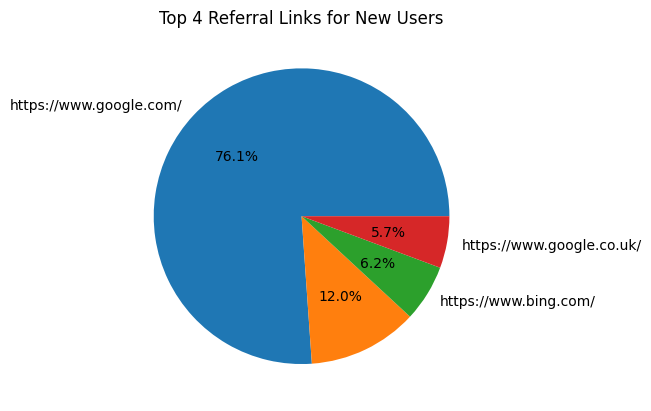

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import count, col, lit, when

# assuming your DataFrame is called 'df'
# create a temporary DataFrame with counts of sessions per unique ID

temp_df = df.groupBy('msg_WebContext_AnonymousId').agg(count('msg_WebContext_SessionId').alias('session_count'))


# create a new column with boolean values based on the count of sessions
new_user_col = when(col('session_count') == lit(1), True).otherwise(False)

# join the original DataFrame with the temporary DataFrame and add the new column
df_with_new_column = df.join(temp_df, on='msg_WebContext_AnonymousId', how='left').withColumn('new_user', new_user_col)

# filter the new users
new_users_df = df_with_new_column.filter(col('new_user') == True)

# group by referral link and count the number of new users for each link
referral_counts_df = new_users_df.groupBy('msg_WebContext_Page_Referrer').agg(count('msg_WebContext_AnonymousId').alias('new_user_count'))

# sort by new user count in descending order and take the top 4
top_referrals_df = referral_counts_df.orderBy(col('new_user_count').desc()).limit(4)

# convert to Pandas DataFrame for plotting
top_referrals_pd = top_referrals_df.toPandas()

# create the pie chart
plt.pie(top_referrals_pd['new_user_count'], labels=top_referrals_pd['msg_WebContext_Page_Referrer'], autopct='%1.1f%%')
plt.title('Top 4 Referral Links attracting the Fresh Users')
plt.show()



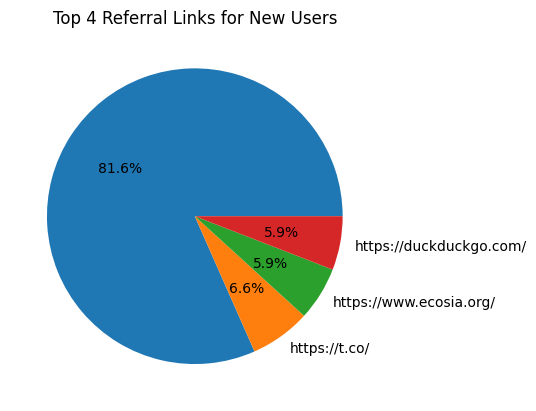

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt


# temp_df with counts of sessions per unique ID
df =df.filter(col('traffic')=='Referrer')
temp_df = df.groupBy('msg_WebContext_AnonymousId').agg(F.count('msg_WebContext_SessionId').alias('session_count'))

# New column with boolean values based on the count of sessions
new_user_col = F.when(F.col('session_count') == F.lit(1), True).otherwise(False)

# join the original DataFrame with the temporary DataFrame and add the new column
df_with_new_column = df.join(temp_df, on='msg_WebContext_AnonymousId', how='left').withColumn('new_user', new_user_col)

# filtering the fresh users
new_users_df = df_with_new_column.filter(F.col('new_user') == True)

# group by referral link and count the number of fresh users for each link
referral_counts_df = new_users_df.groupBy('msg_WebContext_Page_Referrer').agg(F.count('msg_WebContext_AnonymousId').alias('new_user_count'))

# Top 4 Referrals
top_referrals_df = referral_counts_df.orderBy(F.col('new_user_count').desc()).limit(4)

data = top_referrals_df.collect()
plt.pie([row['new_user_count'] for row in data], labels=[row['msg_WebContext_Page_Referrer'] for row in data], autopct='%1.1f%%')
plt.title('Top 4 Referral Links for New Users')
plt.show()


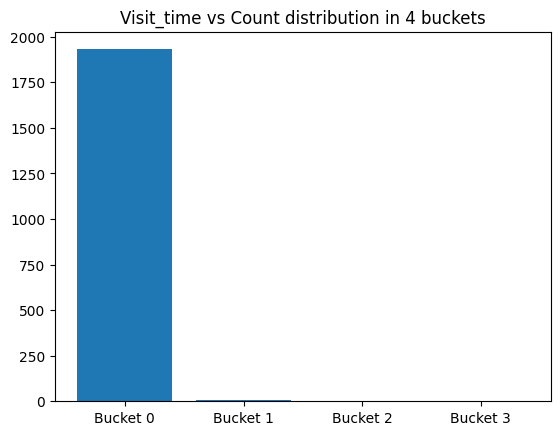

In [ ]:


df = df.withColumn("start_time_unix", unix_timestamp("start_time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")) \
    .withColumn("end_time_unix", unix_timestamp("end_time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))


visit_time_df = df.withColumn("visit_time", col('end_time_unix')-col('start_time_unix'))

visit_time_df=visit_time_df.groupBy('msg_WebContext_AnonymousId').agg(avg('visit_time').alias('avg_visit_time'))

max_avg_time = visit_time_df.select(max(col('avg_visit_time'))).collect()[0][0]
min_avg_time = visit_time_df.select(min(col('avg_visit_time'))).collect()[0][0]

bucket_size = (max_avg_time - min_avg_time) / 4
visit_time_df = visit_time_df.withColumn('bucket', floor((col('avg_visit_time') - min_avg_time) / bucket_size))


bucket_counts = visit_time_df.groupBy('bucket').count().orderBy('bucket').collect()

bucket_labels = ['Bucket ' + str(i) for i in range(4)]
bucket_values = [bucket_counts[i][1] for i in range(4)]

plt.bar(bucket_labels, bucket_values)
plt.title('Visit_time vs Count distribution in 4 buckets')
plt.show()



In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext

df = spark.read.option('header', True).csv("/content/sample_master.csv")
df = df.select('msg_WebContext_AnonymousId','msg_WebContext_SessionId','start_time', 'end_time')
df.count()

5744

In [ ]:
df = df.withColumn("start_time_unix", unix_timestamp("start_time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")) \
    .withColumn("end_time_unix", unix_timestamp("end_time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
visit_time_df = df.withColumn("visit_time", col('end_time_unix')-col('start_time_unix'))
visit_time_df=visit_time_df.groupBy('msg_WebContext_AnonymousId').agg(avg('visit_time').alias('avg_visit_time'))
visit_time_df.show()



+--------------------------+--------------+
|msg_WebContext_AnonymousId|avg_visit_time|
+--------------------------+--------------+
|      e58b15b9-62ab-471...|         119.0|
|      f291d543-d988-470...|          28.0|
|      93a255a3-6bde-49d...|          13.0|
|      e43c375f-daf3-4b3...|         329.0|
|      cd64f5f5-a57a-4d9...|          14.0|
|      a35204b4-6a7b-4bf...|         118.0|
|      3a24cbf3-ff9e-47e...|        4245.0|
|      52c7dce9-0c35-4df...|         358.0|
|      87d47907-242c-4f1...|         456.0|
|      7a5f4a71-852b-456...|           7.0|
|      82442b3e-8b38-4c3...|         147.0|
|      9ab90e3b-9fc2-404...|          42.0|
|      c80a7297-bb93-4ce...|        1387.0|
|      1d6326d4-e440-41b...|          17.0|
|      52346f77-015f-494...|         104.0|
|      555b7cb6-c9ed-467...|         467.0|
|      d46314dc-c91a-4f6...|         101.0|
|      915a21e0-8fb9-4c4...|        1582.0|
|      4d1a2449-41b7-4b9...|         182.0|
|      c20a1dea-b92d-4ee...|    

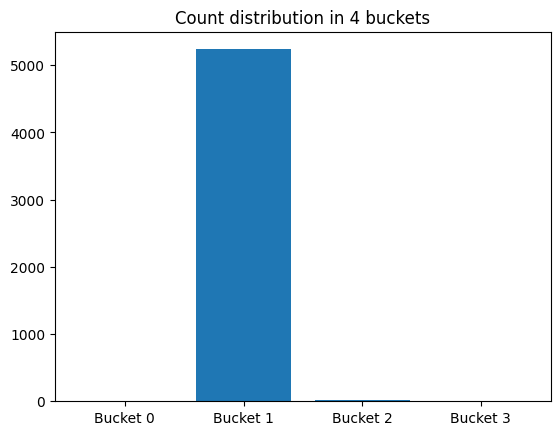

In [ ]:
import matplotlib.pyplot as plt
# from pyspark.ml.feature import Bucketizer as bucketizer

from pyspark.sql.functions import col, min, max, floor


max_avg_time = visit_time_df.select(max(col('avg_visit_time'))).collect()[0][0]
min_avg_time = visit_time_df.select(min(col('avg_visit_time'))).collect()[0][0]


bucket_size = (max_avg_time - min_avg_time) / 4
visit_time_df = visit_time_df.withColumn('bucket', floor((col('avg_visit_time') - min_avg_time) / bucket_size))

# Count distribution in 4 buckets
bucket_counts = visit_time_df.groupBy('bucket').count().orderBy('bucket').collect()
print()



# Plot a bar diagram
import matplotlib.pyplot as plt

bucket_labels = ['Bucket ' + str(i) for i in range(4)]
bucket_values = [bucket_counts[i][1] for i in range(4)]

plt.bar(bucket_labels, bucket_values)
plt.title('Count distribution in 4 buckets')
plt.show()



In [ ]:
from pyspark.sql.functions import lag, col, unix_timestamp, avg, desc
from pyspark.sql.window import Window

# convert start_time and end_time columns to Unix timestamp::: 2023-02-01T19:17:21.758Z
df = df.withColumn("start_time_unix", unix_timestamp("start_time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'")) \
    .withColumn("end_time_unix", unix_timestamp("end_time", "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))

# # create a window specification partitioned by user id and ordered by start time
window_spec = Window.partitionBy("msg_WebContext_AnonymousId").orderBy("start_time")

# # calculate previous session end time and current session start time
prev_end_time = lag("end_time_unix", 1).over(window_spec)
curr_start_time = col("start_time_unix")

absence_time = (curr_start_time - prev_end_time).alias("absence_time")


avg_absence_time = df.select("msg_WebContext_AnonymousId", absence_time).groupBy("msg_WebContext_AnonymousId") \
    .agg(avg("absence_time").alias("avg_absence_time"))


avg_absence_time.orderBy(desc("avg_absence_time")).show()


+--------------------------+-----------------+
|msg_WebContext_AnonymousId| avg_absence_time|
+--------------------------+-----------------+
|      06ba5034-ea63-4ce...|          34081.5|
|      49d985b2-da0c-42f...|          32433.0|
|      4828bb98-27a0-42b...|          19752.0|
|      74155379-aeff-4a1...|          19126.0|
|      3c8ef77d-a0d1-4e1...|          18742.0|
|      a8471e79-d0fa-40a...|          17980.0|
|      5f83d3ba-b07c-413...|          17581.0|
|      1016fdda-26ca-455...|          13642.0|
|      1971dfc9-31b7-447...|          10716.0|
|      03fcfdcb-95fc-47d...|          10697.0|
|      60cf124e-1dc5-49b...|           9308.0|
|      f5c39c68-e68d-469...|           8934.0|
|      dc33943e-abf9-4ca...|           8922.0|
|      3b7fe624-f31a-465...|           8520.0|
|      1230f026-e283-4ed...|           7993.0|
|      ae6608fc-495d-49a...|6841.666666666667|
|      52ae0725-379e-475...|           6623.0|
|      c472f77a-ce5e-4c0...|           6616.0|
|      7a6564

In [ ]:

# Filter out null values from the 'max_instance_scroll' column
# df.na.drop(subset=["max_instance_scroll"])
df = df.filter(~col('max_scroll').isin(['null']))


In [ ]:
page_data = df.select('msg_WebContext_Page_Title','max_scroll').groupBy('msg_WebContext_Page_Title').agg(avg(col('max_scroll')).alias('avg_max_scroll'))
page_data.show()

+-------------------------+------------------+
|msg_WebContext_Page_Title|    avg_max_scroll|
+-------------------------+------------------+
|     Must see attracti...|              62.5|
|     Must see attracti...|              75.0|
|     A new national pa...|33.333333333333336|
|     The lavish Malibu...|              75.0|
|     Best hotels and h...|              75.0|
|     Chiang Mai travel...|58.333333333333336|
|     Sasha Brady - Lon...|              25.0|
|     Everything you ne...|              75.0|
|     15 best things to...|              75.0|
|     Plettenberg Bay t...|              50.0|
|     Why people are st...|              75.0|
|     Top 15 best thing...|              25.0|
|     Best things to do...|              50.0|
|     Thailand travel g...|              87.5|
|     10 best places to...|              62.5|
|     10 best things to...|              75.0|
|     Entertainment Maa...|              75.0|
|     Italy Travel Guid...|              50.0|
|     Best ho

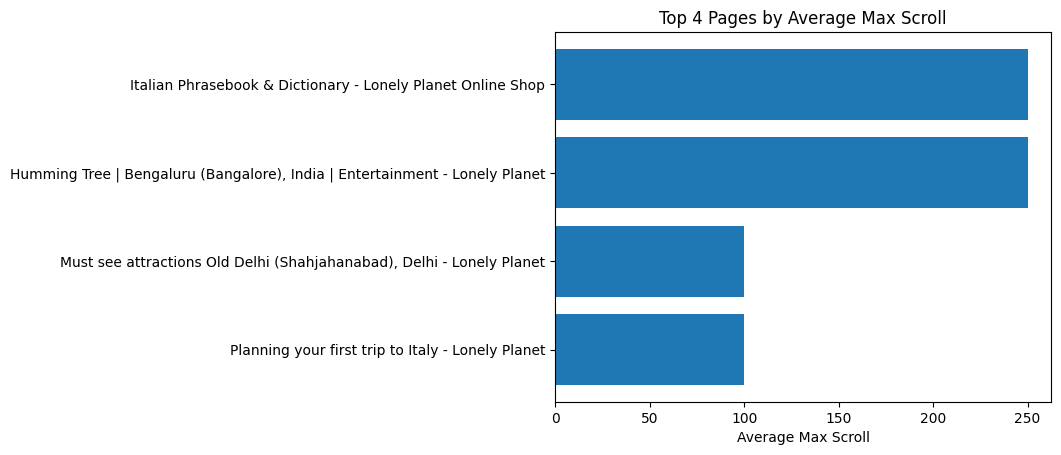

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

page_data = df.select('msg_WebContext_Page_Title', 'max_scroll') \
              .groupBy('msg_WebContext_Page_Title') \
              .agg(avg(col('max_scroll')).alias('avg_max_scroll')) \
              .orderBy('avg_max_scroll', ascending=False) \
              .limit(4) \
              .toPandas()

fig, ax = plt.subplots()

y_pos = np.arange(len(page_data['msg_WebContext_Page_Title']))
ax.barh(y_pos, page_data['avg_max_scroll'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(page_data['msg_WebContext_Page_Title'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Max Scroll')
ax.set_title('Top 4 Pages by Average Max Scroll')

plt.show()


In [ ]:
from pyspark.sql.functions import avg
# Cache the DataFrame in memory
df.cache()
user_data = df.select('msg_WebContext_AnonymousId','max_scroll').groupBy('msg_WebContext_AnonymousId').agg(avg(col('max_scroll')).alias('avg_max_scroll'))
user_data.show()



+--------------------------+--------------+
|msg_WebContext_AnonymousId|avg_max_scroll|
+--------------------------+--------------+
|      527d10ec-17da-459...|          25.0|
|      e43daade-7ca4-463...|          75.0|
|      e986a811-0dd0-409...|          75.0|
|      e9aea61a-8794-4e9...|          75.0|
|      4608df5c-64b6-410...|          75.0|
|      82700f5b-422d-479...|          50.0|
|      01e3c177-78b9-4aa...|         100.0|
|      65aecece-89fa-431...|         100.0|
|      6d00e73d-9024-42e...|          75.0|
|      7a54cbb8-69e8-46a...|          25.0|
|      b5d3474a-c731-432...|          75.0|
|      b93b7114-9091-4c7...|          75.0|
|      c6e9355f-0fde-4eb...|          75.0|
|      f1ddde95-5115-464...|          75.0|
|      1a24c855-9260-40b...|          75.0|
|      2305ece2-f805-48e...|          50.0|
|      536c3e23-3aab-4ec...|         100.0|
|      6028e0ed-cf7e-4d1...|         100.0|
|      726f0816-3719-41a...|          75.0|
|      4872fde2-cc8c-41a...|    

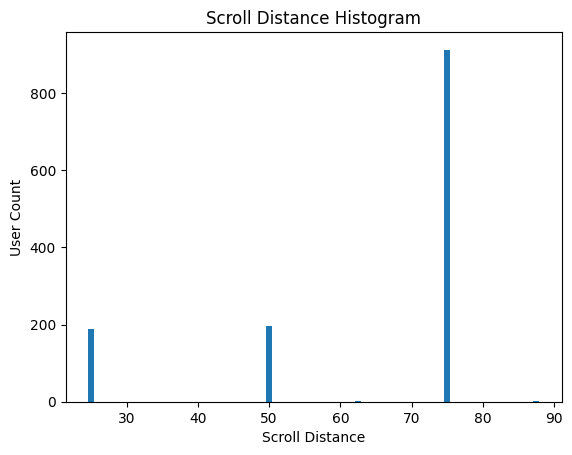

In [ ]:

histogram_data = user_data.groupBy('avg_max_scroll').count().orderBy('avg_max_scroll').limit(5).collect()

# Extract the values from the histogram data
scroll_distance = [row['avg_max_scroll'] for row in histogram_data]
user_count = [row['count'] for row in histogram_data]

# Plot the histogram using Matplotlib
plt.bar(scroll_distance, user_count)
plt.title("Scroll Distance Histogram")
plt.xlabel("Scroll Distance")
plt.ylabel("User Count")
plt.show()

In [ ]:
spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext
df = spark.read.option('header', True).csv("/content/lp_sample_session_data_v2.csv")
df = df.select('msg_WebContext_AnonymousId','sent_at','')
# 0ca1648f-a10f-4a4b-b11e-a0e1e49f4d31
#AVG Ansence time
df.show()

+--------------------------+
|msg_WebContext_AnonymousId|
+--------------------------+
|      003b5c0d-ede2-478...|
+--------------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext
df = spark.read.option('header', True).csv("/content/lp_session_example.csv")

df.show()

+---------------------+-----------------------+-----------+--------------+-------+---------------+--------------------+--------------+-------------+--------------------+----------------+-------------------+-----------------------+-------------+---------------+--------------------+-------------------+---------------------+-----------------------+--------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-------------------+--------------------+----------------------+-------------+--------------------+------------+-------------------+---------------------------+----------------------------+-----------------------------------+--------------------+--------------------+--------------------------+--------------------------+--------------------+--------------------------+---------------------------+----------------------------------+-------+--------+----+------+------+----+-----------+------------+---------------+----------+

In [ ]:
df = df.filter(~col('max_instance_scroll').isin(['null']))

In [ ]:
df.select('scroll_use').distinct().show()

AnalysisException: ignored

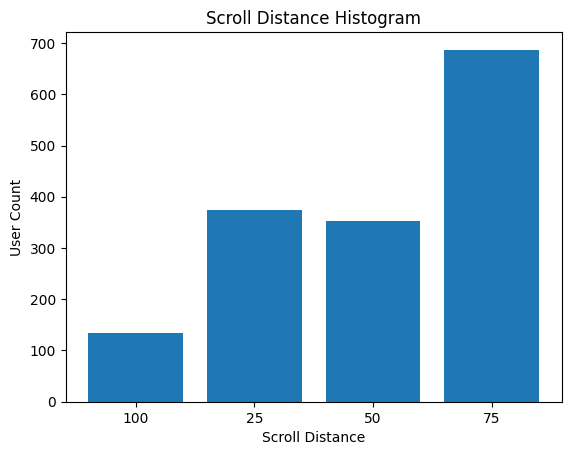

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext
df = spark.read.option('header', True).csv("/content/lp_sample_session_data_v2.csv")

# Filter out null values from the 'max_instance_scroll' column
# df.na.drop(subset=["max_instance_scroll"])
df = df.filter(~col('max_instance_scroll').isin(['null']))

# Cache the DataFrame in memory
df.cache()

# Create a histogram of the 'max_instance_scroll' column
histogram_data = df.groupBy('max_instance_scroll').count().orderBy('max_instance_scroll').collect()

# Extract the values from the histogram data
scroll_distance = [row['max_instance_scroll'] for row in histogram_data]
user_count = [row['count'] for row in histogram_data]

# Plot the histogram using Matplotlib
plt.bar(scroll_distance, user_count)
plt.title("Scroll Distance Histogram")
plt.xlabel("Scroll Distance")
plt.ylabel("User Count")
plt.show()


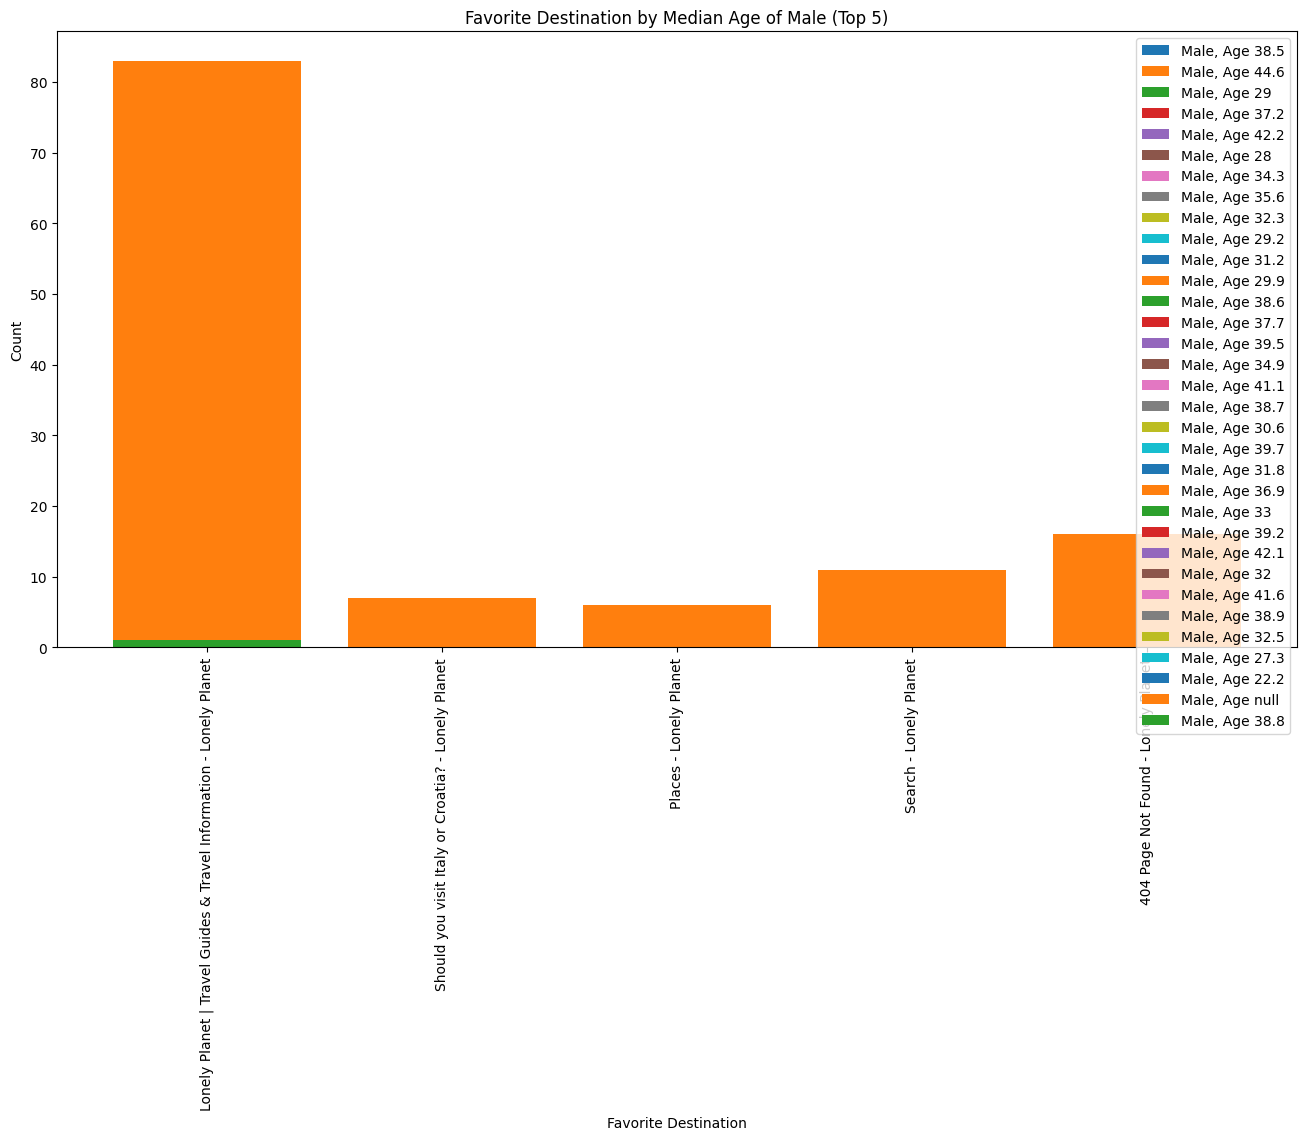

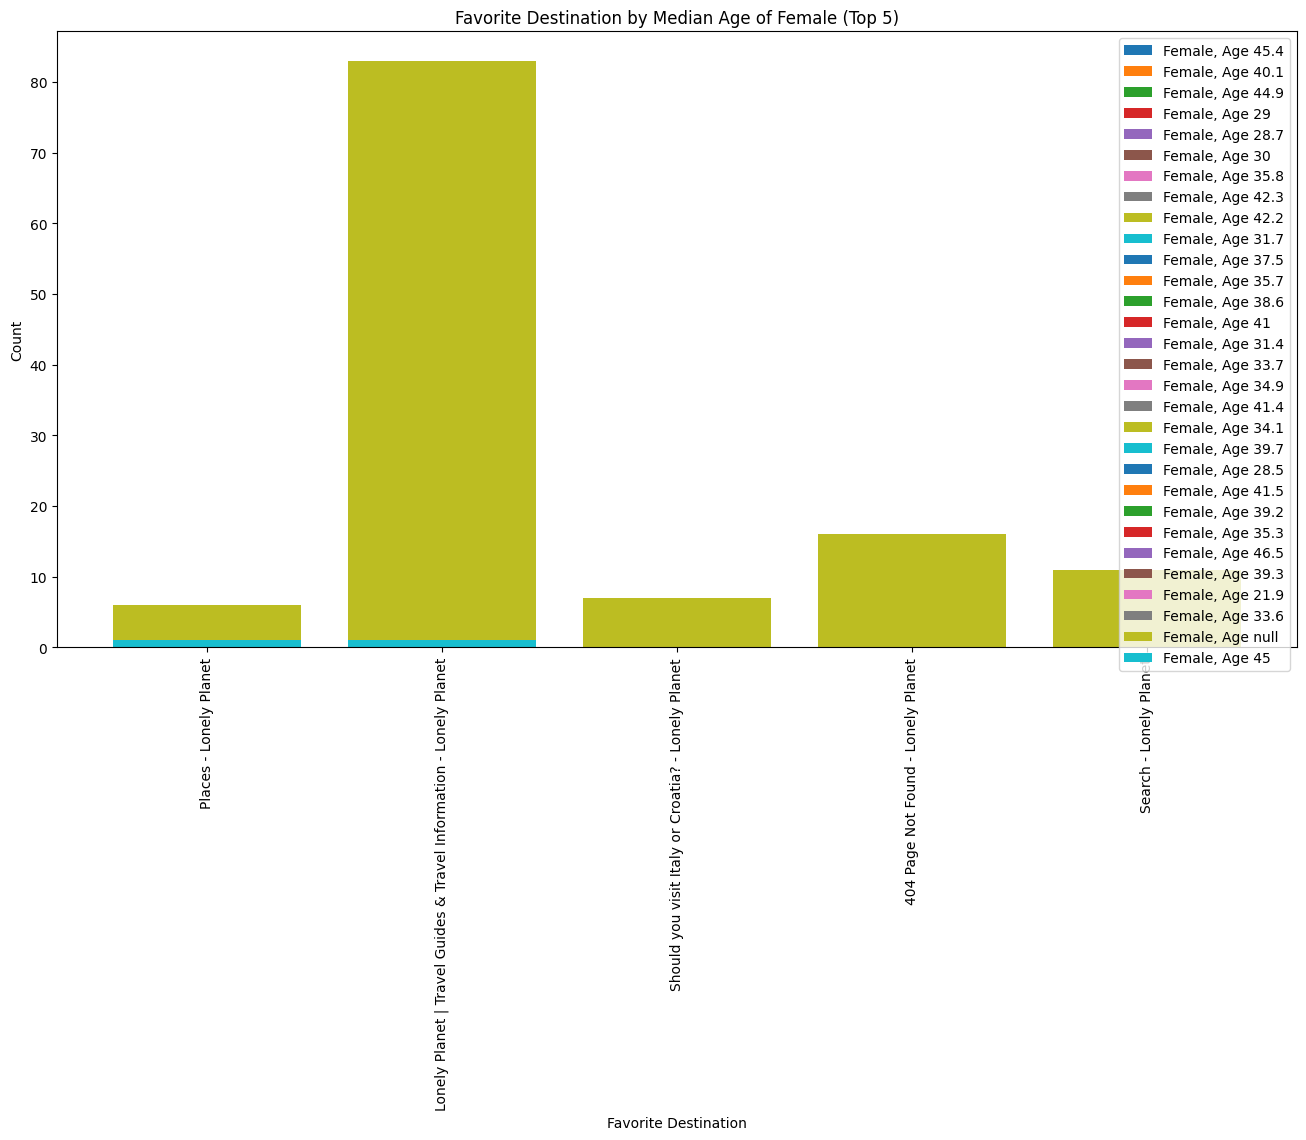

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Group by median age of male and favorite destination
grouped_df = df.groupBy('msg_ZipDemographics_MedianAgeMale', 'msg_WebContext_Page_Title') \
                .count() \
                .withColumnRenamed('count', 'count_total')

# Get the top 5 favorite destinations for both genders
top_destinations = grouped_df.groupBy('msg_WebContext_Page_Title') \
                            .sum('count_total') \
                            .orderBy(col('sum(count_total)').desc()) \
                            .limit(5) \
                            .select('msg_WebContext_Page_Title')

# Filter the data to only include the top 5 favorite destinations
grouped_df = grouped_df.join(top_destinations, 'msg_WebContext_Page_Title', 'inner')

# Group by median age of female and favorite destination
female_grouped_df = df.groupBy('msg_ZipDemographics_MedianAgeFemale', 'msg_WebContext_Page_Title') \
                    .count() \
                    .withColumnRenamed('count', 'count_total')

# Get the top 5 favorite destinations for females
female_top_destinations = female_grouped_df.groupBy('msg_WebContext_Page_Title') \
                                            .sum('count_total') \
                                            .orderBy(col('sum(count_total)').desc()) \
                                            .limit(5) \
                                            .select('msg_WebContext_Page_Title')

# Filter the data to only include the top 5 favorite destinations for females
female_grouped_df = female_grouped_df.join(female_top_destinations, 'msg_WebContext_Page_Title', 'inner')

# Create a bar chart for males
plt.figure(figsize=(16,8))

for age in grouped_df.select('msg_ZipDemographics_MedianAgeMale').distinct().collect():
    age = age[0]
    data = grouped_df.filter(col('msg_ZipDemographics_MedianAgeMale') == age).toPandas()
    plt.bar(data['msg_WebContext_Page_Title'], data['count_total'], label=f"Male, Age {age}")

plt.xticks(rotation=90)
plt.xlabel('Favorite Destination')
plt.ylabel('Count')
plt.legend()
plt.title('Favorite Destination by Median Age of Male (Top 5)')
plt.show()

# Create a bar chart for females
plt.figure(figsize=(16,8))

for age in female_grouped_df.select('msg_ZipDemographics_MedianAgeFemale').distinct().collect():
    age = age[0]
    data = female_grouped_df.filter(col('msg_ZipDemographics_MedianAgeFemale') == age).toPandas()
    plt.bar(data['msg_WebContext_Page_Title'], data['count_total'], label=f"Female, Age {age}")

plt.xticks(rotation=90)
plt.xlabel('Favorite Destination')
plt.ylabel('Count')
plt.legend()
plt.title('Favorite Destination by Median Age of Female (Top 5)')
plt.show()


In [ ]:
Pyspark_df = Pyspark_df.na.drop(subset=["msg_EngagementDuration", "msg_WebContext_Page_Title"])
Pyspark_df.show()

+--------------------------+------------------------+--------------------+-----------------------+--------------------------+--------------------+----------------------+-----------------------+------------------------+--------------------+--------------------------+-----------------------+----------------------------+---------------------+----------------------+----------------------------------+------------------------+-------------------------------------+-----------------------------+------------------------------------+----------------------------------------+--------------------------------------+----------------------------+----------------------------------+--------------------------------------+-----------------------------+-----------------------------------+---------------------------------+---------------------------------------+------------------------------+------------------------------+--------------------+----------------+----------------------------------+-------------

44568
+----------------------------+-----+-------------------+
|msg_WebContext_Page_Referrer|count|         percentage|
+----------------------------+-----+-------------------+
|        https://www.googl...|33521| 0.7521315742236583|
|        https://www.googl...| 3624|0.08131394722670975|
|        https://www.bing....| 2572|0.05770956740262072|
|        https://www.lonel...| 2489|0.05584724465984563|
|        http://m.facebook...| 2362|0.05299766648716568|
+----------------------------+-----+-------------------+



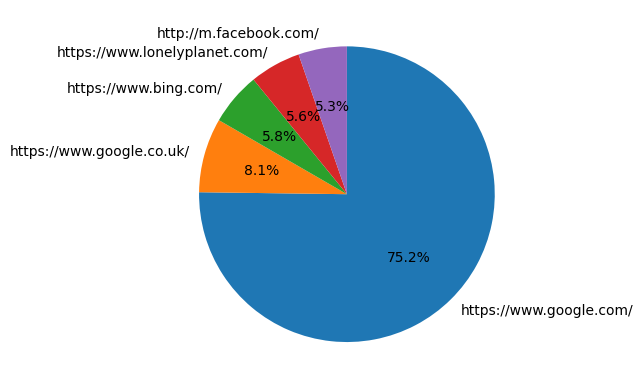

In [ ]:
#Engagement Duration
#1. Top Pages with Maximum Enagement Duration
#2. pie chart showing the breakdown of msg_WebContext_Page_Referrer and further breakdown each portion of msg_WebContext_Page_Referrer with percentage of msg_Geography_Country_Name
#Group by referral site
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

spark = SparkSession.builder.master('local[1]').appName('CS_DATA').getOrCreate()
sc = SparkContext
Pyspark_df = spark.read.option('header', True).csv("/content/export.csv")


Pyspark_df = Pyspark_df.na.drop(subset=["msg_WebContext_Page_Referrer", "msg_Geography_Country_Name"])


ref_country_counts = Pyspark_df.groupBy("msg_WebContext_Page_Referrer").count().orderBy(col('count').desc()).limit(5)

print(ref_country_counts.select(F.sum("count")).collect()[0][0])
ref_counts = ref_country_counts.withColumn(
    "percentage", F.col("count")/ref_country_counts.select(F.sum("count")).collect()[0][0])
ref_counts.show()
listValues= ref_counts.select("count").rdd.map(lambda x : x[0]).collect()

# Create the pie chart
fig, ax = plt.subplots()
ax.axis("equal")
pie_wedge_collection, texts, autotexts = ax.pie(
    listValues,
    labels=ref_counts.select("msg_WebContext_Page_Referrer").rdd.map(lambda x : x[0]).collect(),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
)

plt.show()
